<a href="https://colab.research.google.com/github/toth235a/cracks/blob/main/Crack_segmentation_with_Mask2Former2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a notebook for recognising cracks using a deep learning (Mask2Former)  segmentation model trained on public crack datasets. You can use a web image or images stored on your disk.

Let's download the model and define the functions needed.

Before executing this cell, makes sure colab uses a GPU. To do this, **click Runtime > Change Runtime type > T4 GPU > Save**.


In [ ]:
from transformers import Mask2FormerImageProcessor
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import Mask2FormerForUniversalSegmentation
import requests
from io import BytesIO
from google.colab import files
import io
import logging
from IPython.display import display
import io

logging.getLogger().setLevel(logging.ERROR)

id2label= {0: 'background', 1: 'crack'}
model = Mask2FormerForUniversalSegmentation.from_pretrained("toth235a/mask2former-swin-large-crack-semantic",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)
preprocessor2 = Mask2FormerImageProcessor(ignore_index=255, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


def upload_images(): #function to upload an image to colab
    uploaded = files.upload()  # This will prompt for file upload
    images_list = []  # Initialize an empty list to store image objects

    if uploaded:
        for filename in uploaded.keys():
            print(f"Uploaded file: {filename}")
            # Convert the byte data to a PIL image
            image = Image.open(io.BytesIO(uploaded[filename]))
            images_list.append(image)  # Append the image object to the list
            display(image)  # Display the image that was uploaded

        print("Number of files uploaded:", len(uploaded.keys()))  # Display the number of uploaded files
    else:
        print("No file uploaded.")

    return images_list  # Return the list of PIL image objects
def upload_from_web(url):
  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
  response = requests.get(url, headers=headers)
  img = BytesIO(response.content)
  display(Image.open(img))
  return Image.open(img)



Now we download a crack image from the internet and recognise the cracks in it using the model. Alternatively, if you want to upload images from your local disk, comment out the first line (that uses the upload_from_web function) and restore the second line (that uses the upload_images function).

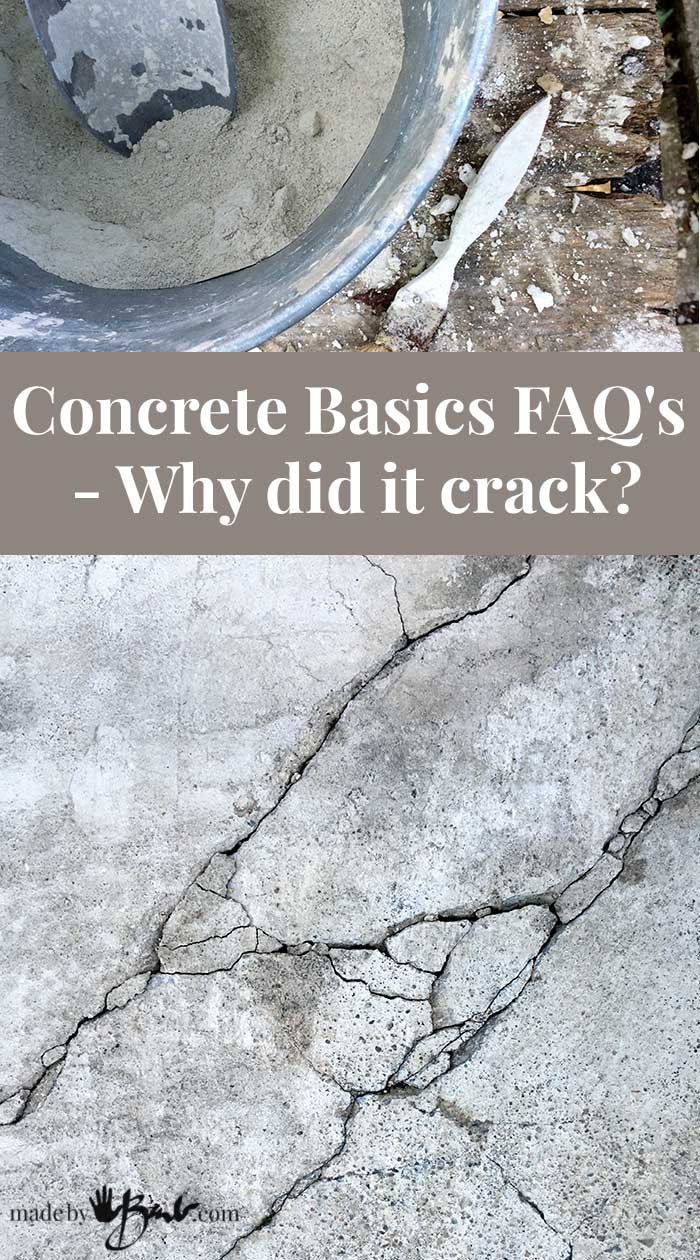

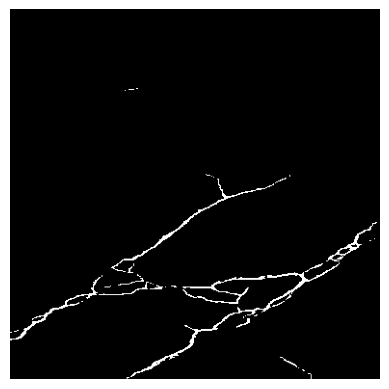

In [ ]:
crack_images = [upload_from_web("https://www.madebybarb.com/wp-content/uploads/2022/11/Concrete-Basics-FAQs-Why-did-it-crack-madebybarb-feature.jpg")]

#crack_images = upload_images()
for crack_image in crack_images:
    original_width, original_height = crack_image.size
    max_dim = max(original_width, original_height)
    scale_factor = 512 / max_dim if max_dim > 512 else 1

    inputs = preprocessor2(crack_image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values.to(device))

    predicted_segmentation_maps = preprocessor2.post_process_semantic_segmentation(outputs)
    segmentation_map = predicted_segmentation_maps[0].cpu()

    # Convert tensor to numpy, adjust dtype to uint8 if necessary
    segmentation_array = segmentation_map.numpy()
    if segmentation_array.dtype != np.uint8:
        segmentation_array = (segmentation_array * 255).astype(np.uint8)  # Normalize to 0-255 if needed

    segmentation_image = Image.fromarray(segmentation_array)

    # Resize prediction to maintain original aspect ratio and scale
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)
    resized_segmentation_image = segmentation_image.resize((new_width, new_height), Image.ANTIALIAS)

    plt.imshow(resized_segmentation_image, cmap='gray')
    plt.axis('off')
    plt.show()

# for crack_image in crack_images:
#   inputs = preprocessor2(crack_image, return_tensors="pt")
#   pixel_values = inputs["pixel_values"]
#   with torch.no_grad():
#       outputs = model(pixel_values=pixel_values.to(device))
#   predicted_segmentation_maps = preprocessor2.post_process_semantic_segmentation(outputs)
#   segmentation_map = predicted_segmentation_maps[0].cpu()
#   plt.imshow(segmentation_map, cmap='gray')
#   plt.axis('off')
#   plt.show()